In [1]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.base import BaseEstimator
import torch.optim as optim
import pandas as pd
import numpy as np
import torch

import warnings
warnings.filterwarnings("ignore")

# 1) Loading train and test datasets

In [13]:
train_df = pd.read_csv('train_data.csv')
test_df = pd.read_csv('test_data.csv')

In [3]:
train_df.head()

,label,text,cleaned_text,preprocessed_tokens,punctuation_percentage,num_chars,num_sentences,num_words,num_misspellings,misspelling_percentage,...,emotions,deception_score,money_score,payment_score,celebration_score,achievement_score,url_presence,phone_number_presence,binary_label,pos_verbs_percentage
0,spam,"calgary , alberta , jul 7 , 2005 ( ccnmatthews...","calgary , alberta , jul 7 , 2005 ( ccnmatthews...","['calgari', 'alberta', 'jul', 'ccnmatthew', 'v...",2.566049,0.028841,0.017150,0.026634,38,0.038000,...,"{'help': 0.004336513443191674, 'office': 0.011...",0.000867,0.015611,0.01301,0.001735,0.002602,0,0,1,0.152000
1,ham,"louise , as of today there is $ 722 , 572 in s...","louise , as of today there is $ 722 , 572 in s...","['louis', 'today', 'schedul', 'c', 'tbg', 'set...",3.571429,0.002575,0.002309,0.002930,8,0.072727,...,"{'help': 0.0, 'office': 0.031007751937984496, ...",0.000000,0.000000,0.00000,0.000000,0.000000,0,0,0,0.190909
2,ham,Lmao but its so fun...,Lmao but its so fun...,"['lmao', 'fun']",13.636364,0.000096,0.000330,0.000160,2,0.333333,...,"{'help': 0.0, 'office': 0.0, 'dance': 0.0, 'mo...",0.000000,0.000000,0.00000,0.000000,0.000000,0,0,0,0.000000
3,ham,hi : here ' s the presentation . - - - - - ori...,hi : here ' s the presentation . - - - - - ori...,"['hi', 'present', 'origin', 'messag', 'kitchen...",8.040712,0.008605,0.004947,0.007484,84,0.298932,...,"{'help': 0.0, 'office': 0.011441647597254004, ...",0.000000,0.002288,0.00000,0.011442,0.000000,0,0,0,0.113879
4,ham,fraud,fraud,['fraud'],0.000000,0.000022,0.000330,0.000027,0,0.000000,...,"{'help': 0.0, 'office': 0.0, 'dance': 0.0, 'mo...",1.000000,0.000000,0.00000,0.000000,0.000000,0,0,0,0.000000


# 2) Model Training
We are using BERT Tiny Uncased model due to computational limitations. 

In [14]:
# Step 1: Create lists for train and test
features = ['num_sentences', 'misspelling_percentage', 'pos_verbs_percentage',
             'spaces_percentage', 'sentiment_score', 'money_score', 'payment_score',
             'celebration_score', 'achievement_score', 'url_presence',
             'phone_number_presence']

train_text_data = train_df['cleaned_text'].astype(str).tolist()
train_numerical_features = train_df[features].values
train_labels = train_df['binary_label'].tolist()

test_text_data = test_df['cleaned_text'].astype(str).tolist()
test_numerical_features = test_df[features].values
test_labels = test_df['binary_label'].tolist()

# Step 2: Tokenization
max_seq_length = 128

tokenizer = BertTokenizer.from_pretrained('prajjwal1/bert-tiny')
train_tokenized_texts = [tokenizer.tokenize(text)[:max_seq_length] for text in train_text_data]  
test_tokenized_texts = [tokenizer.tokenize(text)[:max_seq_length] for text in test_text_data]  

train_input_ids = [tokenizer.convert_tokens_to_ids(tokens) for tokens in train_tokenized_texts]
test_input_ids = [tokenizer.convert_tokens_to_ids(tokens) for tokens in test_tokenized_texts]

# Step 3: Padding
train_input_ids = torch.tensor([ids + [0]*(max_seq_length-len(ids)) for ids in train_input_ids], dtype=torch.long)
test_input_ids = torch.tensor([ids + [0]*(max_seq_length-len(ids)) for ids in test_input_ids], dtype=torch.long)

# Step 4: Combine Text and Numerical Features for Train and Test Data
train_numerical_features_array = np.array(train_numerical_features, dtype=np.float32)
train_numerical_features_tensor = torch.tensor(train_numerical_features_array)

test_numerical_features_array = np.array(test_numerical_features, dtype=np.float32)
test_numerical_features_tensor = torch.tensor(test_numerical_features_array)

train_combined_features = torch.cat([train_input_ids, train_numerical_features_tensor], dim=1)
test_combined_features = torch.cat([test_input_ids, test_numerical_features_tensor], dim=1)

## Model Parameters

In [10]:
# Step 5: Loading and adjusting model parameters

#Parameters
lr = 2e-5
batch_size = 32


#Model and Optimizer
model = BertForSequenceClassification.from_pretrained('prajjwal1/bert-tiny', num_labels=2)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)  # Example optimizer, adjust as needed
train_data = TensorDataset(train_combined_features, torch.tensor(train_labels, dtype=torch.long))
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

Some weights of the model checkpoint at prajjwal1/bert-tiny were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initia

## Training

In [11]:
# Step 6: Model training
model.train()
for epoch in range(1):
    for batch_inputs, batch_labels in train_dataloader:
        optimizer.zero_grad()
        outputs = model(batch_inputs.long(), labels=batch_labels)  # Convert input tensor to long tensor
        loss = outputs.loss
        loss.backward()
        optimizer.step()

## Evaluation
Despite only training for one epoch, the F1-score for both spam and ham texts is relatively high. We will proceed to find out how we can improve the current model through hyperparameter tuning.

In [12]:
# Step 7: Model evaluation
model.eval()
with torch.no_grad():
    logits = model(test_combined_features.long()).logits  # Convert input tensor to long tensor
    predictions = torch.argmax(logits, dim=1)
    predictions = predictions.numpy()
    report = classification_report(test_labels, predictions)
    print(report)

              precision    recall  f1-score   support

           0       0.95      0.97      0.96      7169
           1       0.95      0.92      0.93      4704

    accuracy                           0.95     11873
   macro avg       0.95      0.94      0.95     11873
weighted avg       0.95      0.95      0.95     11873



# 3) Hyperparameter tuning
We split up the different optimizers due to computational constraints, we will then evaluate the performance of the best hyperparameters for each optimzer and choose the best performing model. 

In [7]:
class BertClassifierWrapper(BaseEstimator):
    def __init__(self, num_numerical_features, num_labels=2, optimizer='AdamW', lr=2e-5, num_epochs=3, batch_size=32):
        self.num_numerical_features = num_numerical_features
        self.num_labels = num_labels
        self.optimizer = optimizer
        self.lr = lr
        self.num_epochs = num_epochs
        self.batch_size = batch_size
        
        # Initialize BERT model
        self.bert_model = BertForSequenceClassification.from_pretrained('prajjwal1/bert-tiny', num_labels=num_labels)
        
        # Define additional layers for processing numerical features
        self.linear = torch.nn.Linear(num_numerical_features, 128)
        self.dropout = torch.nn.Dropout(0.1)
        self.activation = torch.nn.ReLU()
        self.final_linear = torch.nn.Linear(128, num_labels)

    def fit(self, X, y):
        # Convert input data to tensors
        numerical_features = torch.tensor(X[:, :self.num_numerical_features], dtype=torch.float32)
        text_features = [str(text) for text in X[:, self.num_numerical_features:]]
        labels = torch.tensor(y, dtype=torch.long)
        tokenizer = BertTokenizer.from_pretrained('prajjwal1/bert-tiny')
        tokenized_texts = [tokenizer.tokenize(text)[:128] for text in text_features]  # Tokenize text-based features
        input_ids = [tokenizer.convert_tokens_to_ids(tokens) for tokens in tokenized_texts]
        input_ids = torch.tensor([ids + [0]*(128-len(ids)) for ids in input_ids], dtype=torch.long)  # Pad tokenized inputs

        # Train the model
        self.bert_model.train()
        if self.optimizer == 'AdamW':
            optimizer = torch.optim.AdamW([
                {'params': self.bert_model.parameters()},
                {'params': self.linear.parameters()},
                {'params': self.final_linear.parameters()}
            ], lr=self.lr)
        elif self.optimizer == 'SGD':
            optimizer = torch.optim.SGD([
                {'params': self.bert_model.parameters()},
                {'params': self.linear.parameters()},
                {'params': self.final_linear.parameters()}
            ], lr=self.lr)
        else:
            raise ValueError("Unsupported optimizer")

        num_batches = len(input_ids) // self.batch_size
        for epoch in range(self.num_epochs):
            for i in range(num_batches):
                batch_input_ids = input_ids[i*self.batch_size:(i+1)*self.batch_size]
                batch_numerical_features = numerical_features[i*self.batch_size:(i+1)*self.batch_size]
                batch_labels = labels[i*self.batch_size:(i+1)*self.batch_size]
                
                optimizer.zero_grad()
                outputs = self.bert_model(input_ids=batch_input_ids)  # Pass tokenized inputs to BERT model
                logits = outputs.logits

                # Additional layers for numerical features
                x = self.linear(batch_numerical_features)
                x = self.activation(x)
                x = self.final_linear(x)

                loss = torch.nn.CrossEntropyLoss()(logits, batch_labels)
                loss.backward()
                optimizer.step()
        return self


    def predict(self, X):
        # Convert input data to tensors
        numerical_features = torch.tensor(X[:, :self.num_numerical_features], dtype=torch.float32)
        
        # Evaluate the model
        self.bert_model.eval()
        with torch.no_grad():
            outputs = self.bert_model(inputs)  # Assuming inputs are already tokenized
            logits = outputs.logits
            
            # Additional layers for numerical features
            x = self.linear(numerical_features)
            x = self.activation(x)
            x = self.final_linear(x)
            
            predictions = torch.argmax(x, dim=1)
        return predictions.numpy()

In [8]:
# Define hyperparameters grid
param_grid = {
    'optimizer': ['AdamW'], #, 'SGD'
    'lr': [2e-3, 2e-1],  # Learning rates to tune
    'num_epochs': [1],  # Number of epochs to tune
    'batch_size': [32, 16]
}


# Create GridSearchCV instance
grid_search = GridSearchCV(estimator=BertClassifierWrapper(num_numerical_features=11, num_labels=2), 
                           param_grid=param_grid, 
                           scoring='f1',  # Choose appropriate scoring metric
                           cv=2)  # Number of cross-validation folds

# Fit the GridSearchCV instance on the training data
grid_search.fit(train_combined_features, train_labels)

# Get the best hyperparameters
best_params = grid_search.best_params_

# Print the best hyperparameters
print("Best Hyperparameters:", best_params)


Some weights of the model checkpoint at prajjwal1/bert-tiny were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initia

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at prajjwal1/bert-tiny and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of the model checkpoint at prajjwal1/bert-tiny were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS N

Best Hyperparameters: {'batch_size': 32, 'lr': 0.002, 'num_epochs': 1, 'optimizer': 'AdamW'}


In [9]:
# Define hyperparameters grid
param_grid = {
    'optimizer': ['SGD'], #, 'SGD'
    'lr': [2e-3, 2e-1],  # Learning rates to tune
    'num_epochs': [1],  # Number of epochs to tune
    'batch_size': [32, 16]
}


# Create GridSearchCV instance
grid_search = GridSearchCV(estimator=BertClassifierWrapper(num_numerical_features=11, num_labels=2), 
                           param_grid=param_grid, 
                           scoring='f1',  # Choose appropriate scoring metric
                           cv=2)  # Number of cross-validation folds

# Fit the GridSearchCV instance on the training data
grid_search.fit(train_combined_features, train_labels)

# Get the best hyperparameters
best_params = grid_search.best_params_

# Print the best hyperparameters
print("Best Hyperparameters:", best_params)


Some weights of the model checkpoint at prajjwal1/bert-tiny were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initia

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at prajjwal1/bert-tiny and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of the model checkpoint at prajjwal1/bert-tiny were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS N

Best Hyperparameters: {'batch_size': 32, 'lr': 0.002, 'num_epochs': 1, 'optimizer': 'SGD'}


# Testing best model for each optimizer

In [10]:
#Parameters
lr = 2e-3
batch_size = 32

In [11]:
#Model 1 Adam Optimiser
model1 = BertForSequenceClassification.from_pretrained('prajjwal1/bert-tiny', num_labels=2)
optimizer = torch.optim.Adam(model1.parameters(), lr=lr)  # Example optimizer, adjust as needed
train_data = TensorDataset(train_combined_features, torch.tensor(train_labels, dtype=torch.long))
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    
model1.train()
for epoch in range(1):
    for batch_inputs, batch_labels in train_dataloader:
        optimizer.zero_grad()
        outputs = model1(batch_inputs.long(), labels=batch_labels)  # Convert input tensor to long tensor
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        
model1.eval()
with torch.no_grad():
    logits = model1(test_combined_features.long()).logits  # Convert input tensor to long tensor
    predictions = torch.argmax(logits, dim=1)
    predictions = predictions.numpy()
    report = classification_report(test_labels, predictions)
    print('Model 1 (Adam): \n',report)

Some weights of the model checkpoint at prajjwal1/bert-tiny were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initia

Model 1 (Adam): 
               precision    recall  f1-score   support

           0       0.89      0.96      0.92      7169
           1       0.93      0.81      0.87      4704

    accuracy                           0.90     11873
   macro avg       0.91      0.89      0.90     11873
weighted avg       0.91      0.90      0.90     11873



In [12]:
# Model 2 SGD Optimiser    
model2 = BertForSequenceClassification.from_pretrained('prajjwal1/bert-tiny', num_labels=2)
optimizer = torch.optim.SGD(model2.parameters(), lr=lr)  # Example optimizer, adjust as needed
train_data = TensorDataset(train_combined_features, torch.tensor(train_labels, dtype=torch.long))
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

model2.train()
for epoch in range(1):
    for batch_inputs, batch_labels in train_dataloader:
        optimizer.zero_grad()
        outputs = model2(batch_inputs.long(), labels=batch_labels)  # Convert input tensor to long tensor
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        
model2.eval()
with torch.no_grad():
    logits = model2(test_combined_features.long()).logits  # Convert input tensor to long tensor
    predictions = torch.argmax(logits, dim=1)
    predictions = predictions.numpy()
    report = classification_report(test_labels, predictions)
    print('Model 2 (SGD): \n', report)

Some weights of the model checkpoint at prajjwal1/bert-tiny were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initia

Model 2 (SGD): 
               precision    recall  f1-score   support

           0       0.95      0.85      0.90      7169
           1       0.81      0.93      0.86      4704

    accuracy                           0.88     11873
   macro avg       0.88      0.89      0.88     11873
weighted avg       0.89      0.88      0.88     11873



# Final Model Training
We will use the chosen model to undergo more epochs (from 1 to 3) during training so as to achieve a better performing model. Most open source forums discuss that fine tuning pre-existing BERT models should not exceed 5 epochs.  

In [16]:
import matplotlib.pyplot as plt

training_loss_values = []

final_model = BertForSequenceClassification.from_pretrained('prajjwal1/bert-tiny', num_labels=2)
optimizer = torch.optim.Adam(final_model.parameters(), lr=lr) 
train_data = TensorDataset(train_combined_features, torch.tensor(train_labels, dtype=torch.long))
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

final_model.train()
for epoch in range(6):
    epoch_loss = 0.0  
    for batch_inputs, batch_labels in train_dataloader:
        optimizer.zero_grad()
        outputs = final_model(batch_inputs.long(), labels=batch_labels)  # Convert input tensor to long tensor
        loss = outputs.loss
        epoch_loss += loss.item()  
        loss.backward()
        optimizer.step()
    
    epoch_loss /= len(train_dataloader)
    training_loss_values.append(epoch_loss)

# Evaluation
final_model.eval()
with torch.no_grad():
    logits = final_model(test_combined_features.long()).logits  # Convert input tensor to long tensor
    predictions = torch.argmax(logits, dim=1)
    predictions = predictions.numpy()
    report = classification_report(test_labels, predictions)
    print(report)

Some weights of the model checkpoint at prajjwal1/bert-tiny were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initia

              precision    recall  f1-score   support

           0       0.76      0.96      0.85      7169
           1       0.89      0.53      0.67      4704

    accuracy                           0.79     11873
   macro avg       0.82      0.74      0.76     11873
weighted avg       0.81      0.79      0.77     11873



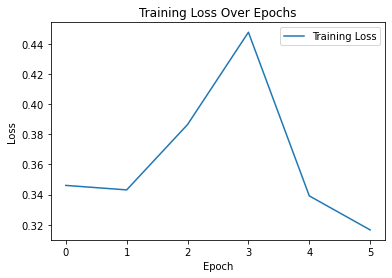

In [17]:
# Plot the training loss
plt.plot(training_loss_values, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.show()

In [18]:
final_model = BertForSequenceClassification.from_pretrained('prajjwal1/bert-tiny', num_labels=2)
optimizer = torch.optim.Adam(final_model.parameters(), lr=lr) 
train_data = TensorDataset(train_combined_features, torch.tensor(train_labels, dtype=torch.long))
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

final_model.train()
for epoch in range(2):
    epoch_loss = 0.0  
    for batch_inputs, batch_labels in train_dataloader:
        optimizer.zero_grad()
        outputs = final_model(batch_inputs.long(), labels=batch_labels)  # Convert input tensor to long tensor
        loss = outputs.loss
        epoch_loss += loss.item()  
        loss.backward()
        optimizer.step()
    
final_model.eval()
with torch.no_grad():
    logits = final_model(test_combined_features.long()).logits  # Convert input tensor to long tensor
    predictions = torch.argmax(logits, dim=1)
    predictions = predictions.numpy()
    report = classification_report(test_labels, predictions)
    print(report)

Some weights of the model checkpoint at prajjwal1/bert-tiny were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initia

              precision    recall  f1-score   support

           0       0.81      0.94      0.87      7169
           1       0.89      0.67      0.76      4704

    accuracy                           0.83     11873
   macro avg       0.85      0.81      0.82     11873
weighted avg       0.84      0.83      0.83     11873



# Conclusion

Despite lower training loss, the model trained using an additional epoch results in poorer performance. Hence, we will adopt the previous model which is trained using 1 epoch using the Adam optimizer. 

In [19]:
# Saving the model
torch.save(model1.state_dict(), 'bert_model.pth')

# Loading the model
model = BertForSequenceClassification.from_pretrained('prajjwal1/bert-tiny', num_labels=2)
model.load_state_dict(torch.load('bert_model.pth'))
model.eval()

Some weights of the model checkpoint at prajjwal1/bert-tiny were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initia

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 128, padding_idx=0)
      (position_embeddings): Embedding(512, 128)
      (token_type_embeddings): Embedding(2, 128)
      (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-1): 2 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=128, out_features=128, bias=True)
              (key): Linear(in_features=128, out_features=128, bias=True)
              (value): Linear(in_features=128, out_features=128, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=128, out_features=128, bias=True)
              (LayerNorm): LayerNorm((128,), eps=1e-12, e

In [10]:
model = BertForSequenceClassification.from_pretrained('prajjwal1/bert-tiny', num_labels=2)
state_dict = torch.load('bert_model.pth')
state_dict.pop('bert.embeddings.position_ids')
model.load_state_dict(state_dict)
model.eval()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at prajjwal1/bert-tiny and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 128, padding_idx=0)
      (position_embeddings): Embedding(512, 128)
      (token_type_embeddings): Embedding(2, 128)
      (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=128, out_features=128, bias=True)
              (key): Linear(in_features=128, out_features=128, bias=True)
              (value): Linear(in_features=128, out_features=128, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=128, out_features=128, bias=True)
              (LayerNorm): LayerNorm((128,), eps=1e-12, element

In [15]:
logits = model(test_combined_features.long()).logits  # Convert input tensor to long tensor
predictions = torch.argmax(logits, dim=1)
predictions = predictions.numpy()

# Initialize counters for false positives and false negatives
fp_count = 0
fn_count = 0
max_count = 10

# Iterate over test examples for false positives
print("False Positive Examples")
for idx in range(len(predictions)):
    # Check if the example is a false positive
    if predictions[idx] == 1 and test_labels[idx] == 0 and fp_count < max_count:
        print("Text:", test_text_data[idx])
        fp_count += 1
    
    # Break loop if we have found 5 examples
    if fp_count >= max_count:
        break

# Iterate over test examples for false negatives
print("\n\nFalse Negative Examples")
for idx in range(len(predictions)):
    # Check if the example is a false negative
    if predictions[idx] == 0 and test_labels[idx] == 1 and fn_count < max_count:
        print("Text:", test_text_data[idx])
        fn_count += 1
    
    # Break loop if we have found 5 examples
    if fn_count >= max_count:
        break

We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


False Positive Examples
Text: who is a close frnd? woh jo pehla aasu tham le phir aansu poch de or phir chehre ko haanthon me tham kar kahe chal drame band kar !! :d
Text: Same here, but I consider walls and bunkers and shit important just because I never play on peaceful but I guess your place is high enough that it don't matter
Text: hello did any of you hear about a a razor plugin for mozilla a plugin that would add a report as spam button somewhere for the user to report a mail as spam on a server arnaud arnaud ablard administrateur rseaux et systmes irin facult de sciences universit de nantes this url email is sponsored by osdn tired of that same old cell phone get a new here for free url razor users mailing list razor users url url
Text: in sigh here is esai ' s latest natural gas fundwatch . edna o ' connell office manager esai 301 edgewater place , suite 108 wakefield , ma 01880 ( 781 ) 245 - 2036 ( 781 ) 245 - 8706 ednao @ esaibos . com - ngol 1900 . pdf
Text: 20210406 204127 